In [1]:
## IMPORTANT: COPY PADDLER LOCATIONS FROM LONGITUDINAL ANALYSIS CASES FOR EACH PADDLER
import _canoeValues as cv

pad_weights = cv.pad_weights
LLF = 1.3
DLF = cv.DLF # Dead Load Factor

# Position of paddlers with respect to left end of canoe (m)
pad_po = [1.250, 2.300, 3.700, 4.650]

# Choose between pad_weights
paddler_weight = [pad_weights[2] * LLF, pad_weights[3] * LLF, pad_weights[3] * LLF, pad_weights[0] * LLF]

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#-----------inputs--------------------
outer_file = "Outer Hull.csv"
concrete_density = cv.concrete_density # Concrete density = 1200 kg/m^3
concrete_thickness = cv.concrete_thickness / 1000
compressive_strength = cv.compressive_strength
#-------------------------------------

# mm over 2, 3, 4, 6 paddlers
grasshopper = cv.grasshopper[2]

script_dir = os.path.abspath('data') # absolute file path in Jupyter

# Read the outer hull coordinates (ONLY USE OUTER HULL FOR TRANSVERSE)
file_path = os.path.join(script_dir, outer_file) # file path for the text file input
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

file_path = os.path.join(script_dir, "Station Information.csv") # file path for the text file input
canoe_info = pd.read_csv(file_path, header=None)
globalStationLength = float(canoe_info[4][22])

yung_modulus_concrete = 4500 * math.sqrt(compressive_strength)
yung_modulus_mesh = 72500 # MPa

N = yung_modulus_mesh / yung_modulus_concrete

area_mesh_per_station = 6.156
# area_mesh_per_mm_transverse = 0.06

ybar_mesh = cv.d_mesh_1

area_equi_concrete = (N-1) * area_mesh_per_station


concrete_thickness_mm = concrete_thickness * 1000

cross_sectional_area_of_concrete = concrete_thickness_mm * globalStationLength
ybar_concrete = concrete_thickness_mm/2



ybar_top = (ybar_mesh * area_equi_concrete + ybar_concrete * cross_sectional_area_of_concrete) / (area_equi_concrete + cross_sectional_area_of_concrete)
ybar_bottom = concrete_thickness_mm - ybar_top

I = (globalStationLength * concrete_thickness_mm**3 / 12)+((concrete_thickness_mm*globalStationLength)*(ybar_top-ybar_concrete)**2)+(area_equi_concrete*(ybar_mesh-ybar_top)**2)

print(I)


8927.924556228665


12
22
36
45


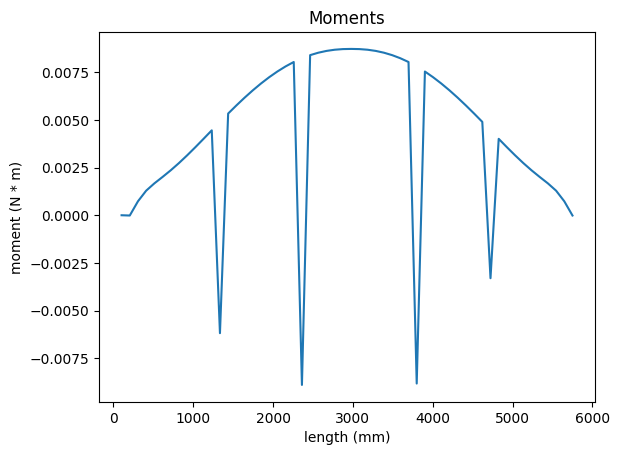

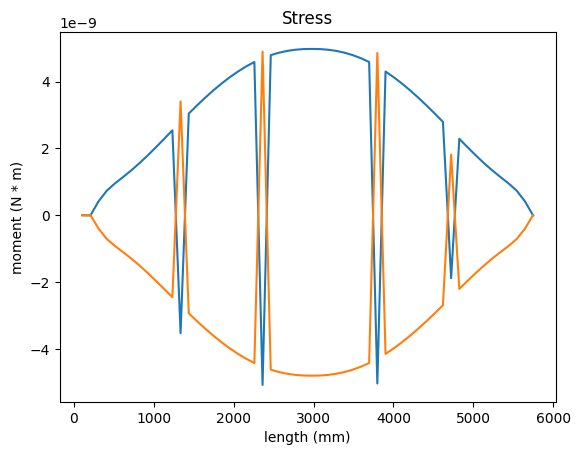

Resistance Top: 19.292539179808994 N*m
Resistance Bottom: 20.003180419277196 N*m


In [3]:
# Outer Hull Volume: Assume station is filled up with concrete
station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station

currentLength = 0
nextPaddler = 0

stress_top = []
stress_bottom = []

resistance_top = []
resistance_bottom = []

station_moments = []

printCrossSectionYOut = []
printCrossSectionZOut = []
printCrossSectionCOMPAREYOut = []
printCrossSectionCOMPAREZOut = []

# Loop through each station
for k in range(0,station_no-1,1):

    # Coordinates of points in the outer frame sharing an X-coordinate with the current station
    X1_value = station[k]
    Y1 = []
    Z1 = []

    # Coordinates of points in the outer frame sharing an X-coordinate with the next station
    X2_value = station[k+1]
    Y2 = []
    Z2 = []

    # Loop through each x coordinate in the outer hull
    for i in range(0,len(x_out),1):

        if(y_out[i] < 0):
            continue

        # If the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
            if k == math.floor(station_no-1 / 2):
                printCrossSectionYOut.append(y_out[i])
                printCrossSectionZOut.append(z_out[i])
            # Compare a station dist to middle
            # Still x_in - only care about the location at inner hull width


        # Otherwise, if the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

    # Calculate length, width, depth and waterline of this station
    station_length = (X2_value - X1_value) / 1000
    station_width = max(Y1) / 1000
    station_depth = abs(min(Z1)) / 1000
    waterline = max(station_depth - grasshopper / 1000, 0)

    moment_arm1 = station_width - concrete_thickness/2
    moment_arm2 = station_width/2
    self_weight1 = concrete_thickness * station_depth * station_length * concrete_density * 9.81 * DLF  # N
    self_weight2 = concrete_thickness * station_width * station_length * concrete_density * 9.81 * DLF # N

    #                              ----------pressure--------- * --------------area---------------
    horizontal_hydrostatic_force = 1000 * 9.81 * waterline / 2 * waterline * station_length
    horizontal_hydrostatic_distance = waterline / 3

    vertical_hydrostatic_force = 1000 * 9.81 * waterline * station_width * station_length
    vertical_hydrostatic_distance = station_width / 2

    # Determine if a paddler is in this station
    current_paddler_weight = 0
    prevLength = currentLength
    currentLength += station_length
    if pad_po[nextPaddler] >= prevLength and pad_po[nextPaddler] < currentLength:
        current_paddler_weight = paddler_weight[nextPaddler]
        print(k)
        if(nextPaddler < len(pad_po) - 1):
            nextPaddler += 1
    moment_arm_paddler = station_width / 2
    
    moment = (horizontal_hydrostatic_force * horizontal_hydrostatic_distance + vertical_hydrostatic_force * vertical_hydrostatic_distance - self_weight1 * moment_arm1 - self_weight2 * moment_arm2 - current_paddler_weight * moment_arm_paddler) / 1000

    stress_top.append(moment*(ybar_top/1000)/I)
    stress_bottom.append(-moment*(ybar_bottom/1000)/I)

    resistance_top.append(compressive_strength * I / (ybar_top) /1000) # Nm
    resistance_bottom.append(compressive_strength * I / (ybar_bottom) /1000)  # Nm
    
    station_moments.append(moment)
    




plt.plot(station[1:57], station_moments)
plt.title('Moments')
plt.xlabel('length (mm)')
plt.ylabel('moment (N * m)')
plt.show()

plt.plot(station[1:57], stress_top)
plt.plot(station[1:57], stress_bottom)
plt.title('Stress')
plt.xlabel('length (mm)')
plt.ylabel('moment (N * m)')
plt.show()

print("Resistance Top:", resistance_top[23], "N*m")
print("Resistance Bottom:", resistance_bottom[23], "N*m")


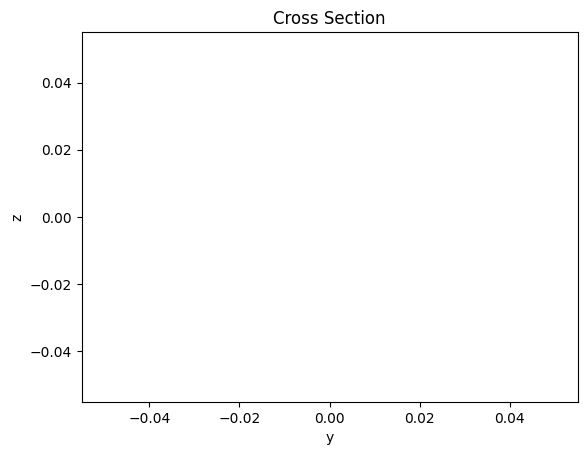

In [4]:
plt.plot(printCrossSectionYOut, printCrossSectionZOut)
plt.plot(printCrossSectionCOMPAREYOut, printCrossSectionCOMPAREZOut)
plt.title('Cross Section')
plt.xlabel('y')
plt.ylabel('z')
plt.show()

# for i in range(len(printCrossSectionYIn)):
#     print(printCrossSectionYIn[i] - printCrossSectionYOut[i], printCrossSectionZIn[i] - printCrossSectionZOut[i])